In [3]:
!pip install datasets > /dev/null

In [4]:
import sys  # модуль для взаємодії з системою
from typing import List, Tuple, Mapping  # використовуємо для визначення типів даних

import datasets  # бібліотека для роботи з даними
from tqdm import tqdm  # для створення прогрес-бару
import numpy as np  # для роботи з масивами даних
import matplotlib.pyplot as plt  # для візуалізації

import torch  # бібліотека для навчання нейромереж
import torch.nn as nn  # модуль нейронних мереж
import torch.optim as optim  # оптимізатори
import torch.nn.functional as F  # функціональні операції над тензорами
from torch.nn.utils.rnn import pad_sequence  # для вирівнювання послідовностей
from torch.utils.data import Dataset, DataLoader  # для роботи з даними та завантаження їх у модель

## Dataset

**[HuggingFace](https://huggingface.co/datasets/benjamin/ner-uk)** <br>
**[GitHub](https://github.com/lang-uk/ner-uk/tree/master)**

In [5]:
dataset = datasets.load_dataset("benjamin/ner-uk")  # завантаження набору даних для розпізнавання іменованих сутностей українською мовою
dataset  # виведення набору даних

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/1.32k [00:00<?, ?B/s]

dataset_infos.json:   0%|          | 0.00/1.02k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/922k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/131k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/74.8k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/10833 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1307 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/668 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 10833
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 1307
    })
    test: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 668
    })
})

In [6]:
# NOTE: буде використано для вирівнювання вхідних послідовностей.
TOK_PAD_ID = 0

vocab = {"<PAD>": TOK_PAD_ID}  # словник, починаємо з індексу для заповнення
curr_idx = 1  # поточний індекс для індексування слів
for split in ("train", "validation", "test"):  # проходимо по наборах даних для навчання, валідації та тестування
    for sample in dataset[split]:  # проходимо по кожному зразку в наборі даних
        for word in sample["tokens"]:  # проходимо по кожному слову в токенах зразку
            if word not in vocab:  # якщо слово ще не зустрічалося
                vocab[word] = curr_idx  # додаємо його до словника з поточним індексом
                curr_idx += 1  # збільшуємо поточний індекс

print("Vocab size:", len(vocab))  # виводимо розмір словника

Vocab size: 50205


In [7]:
# NOTE: буде використано це значення для вирівнювання міток,
#       у функції CrossEntropyLoss є спеціальний параметр, який називається 'ignore_index'
#       і він ігноруватиме мітки з цим значенням (обчислення втрат
#       буде пропущено для міток, які дорівнюють цьому значенню)
NER_PAD_ID = -100

targets = set()  # множина для зберігання унікальних міток іменованих сутностей
for split in ("train", "validation", "test"):  # проходимо по наборах даних для навчання, валідації та тестування
    for sample in dataset[split]:  # проходимо по кожному зразку в наборі даних
        targets.update(sample["ner_tags"])  # додаємо усі мітки зразку до множини

targets = sorted(targets)  # сортуємо унікальні мітки
print("Unique targets:", len(targets))  # виводимо кількість унікальних міток
targets  # виводимо унікальні мітки

Unique targets: 9


[0, 1, 2, 3, 4, 5, 6, 7, 8]

## PyTorch Datasets & DataLoaders

In [8]:
class NERDataset(Dataset):
    def __init__(self, samples: datasets.Dataset, vocabulary: Mapping[str, int]) -> None:
        self.samples = samples  # зразки даних
        self.vocabulary = vocabulary  # словник токенів та їх індексів

    def __len__(self) -> int:
        return len(self.samples)  # повертаємо загальну кількість зразків у наборі даних

    def __getitem__(self, index: int) -> Tuple[torch.LongTensor, torch.LongTensor]:
        sample = self.samples[index]  # вибираємо зразок за індексом
        doc = torch.LongTensor([self.vocabulary[token] for token in sample["tokens"]])  # індексуємо токени зразка
        label = torch.LongTensor(sample["ner_tags"])  # конвертуємо мітки іменованих сутностей у тензор
        return doc, label  # повертаємо тензор токенів та міток іменованих сутностей


In [9]:
def seq_collate_fn(
    batch: List[Tuple[torch.LongTensor, torch.LongTensor]], data_pad: int, label_pad: int
) -> Tuple[torch.LongTensor, torch.LongTensor]:
    """Combine samples into batch that can be used laten by RNN model.

    Args:
        batch: list with tensors that should be packed into batch.
            Expected that each list sample will be a tuple of (text_tokens, label_tokens).
        data_pad: value to use for padding text tokens.
        label_pad: value to use for padding label tokens.

    Returns:
        Padded and packed into batch text tokens and padded and packed into batch label tokens.
    """
    token_ids = pad_sequence([item[0] for item in batch], batch_first=True, padding_value=data_pad)
    label_ids = pad_sequence([item[1] for item in batch], batch_first=True, padding_value=label_pad)
    return token_ids, label_ids


def ner_collate_fn(batch: List[Tuple[torch.LongTensor, torch.LongTensor]]) -> Tuple[torch.LongTensor, torch.LongTensor]:
    """Collator function for our NER dataset.

    Args:
        batch: list with tensors that should be packed into batch.
            Expected that each list sample will be a tuple of (text_tokens, label_tokens).

    Returns:
        Padded and packed into batch text tokens and padded and packed into batch label tokens.
    """
    return seq_collate_fn(batch, TOK_PAD_ID, NER_PAD_ID)

In [11]:
train_dataset = NERDataset(dataset["train"], vocab)  # набір даних для навчання
validation_dataset = NERDataset(dataset["validation"], vocab)  # набір даних для валідації
test_dataset = NERDataset(dataset["test"], vocab)  # набір даних для тестування

len(train_dataset), len(validation_dataset), len(test_dataset)  # вивід кількості зразків у кожному наборі даних

(10833, 1307, 668)

In [12]:
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, collate_fn=ner_collate_fn)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, collate_fn=ner_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=ner_collate_fn)

len(train_loader), len(validation_loader), len(test_loader)  # вивід кількості пакетів у кожному завантажувачі даних

(169, 21, 11)

# Training & Evaluation

In [13]:
def sequence_f1(true_labels: np.array, predicted_labels: np.array) -> np.array:
    """F1 score for one sequence.

    Args:
        true_labels: ground truth labels.
        predicted_labels: model predictions.

    Returns:
        F1 scores for each class.
    """
    assert len(true_labels) == len(predicted_labels), "Mismatched length between true labels and predicted labels"

    scores = []  # список для зберігання значень F1 для кожного класу
    for _cls in targets:  # проходимо по унікальним класам міток
        # обчислюємо кількість true positives, false positives та false negatives для поточного класу
        true_positives = np.sum((true_labels == predicted_labels) & (true_labels == _cls))
        false_positives = np.sum((true_labels != predicted_labels) & (predicted_labels == _cls))
        false_negatives = np.sum((true_labels != predicted_labels) & (true_labels == _cls))

        # обчислюємо точність, відновлення та F1 для поточного класу
        precision = np.nan_to_num(true_positives / (true_positives + false_positives), nan=0.0)
        recall = np.nan_to_num(true_positives / (true_positives + false_negatives), nan=0.0)
        f1_score = np.nan_to_num(2 * (precision * recall) / (precision + recall), nan=0.0)

        scores.append(f1_score)  # додаємо значення F1 до списку
    return np.array(scores)  # повертаємо масив зі значеннями F1 для кожного класу

In [14]:
def train_one_epoch(
    model: nn.Module,
    loader: DataLoader,
    criterion: nn.Module,
    optimizer: optim.Optimizer,
    device: str = "cpu",
    verbose: bool = True,
) -> Mapping[str, np.array]:
    """Train model one epoch.

    Args:
        model: model to train.
        loader: dataloader to use for training.
        criterion: loss function to optimize.
        optimizer: model training algorithm.
        device: device to use for training.
            Default is `"cpu"`.
        verbose: option to print training progress bar.
            Default is `True`.

    Returns:
        dict with training logs
    """
    model.train()  # переведення моделі у режим тренування

    losses = []  # список для зберігання значень втрат
    scores = []  # список для зберігання значень метрики F1

    # ініціалізація прогрес-бару
    with tqdm(total=len(loader), desc="training", file=sys.stdout, ncols=100, disable=not verbose) as progress:
        for x_batch, y_true in loader:  # проходимо по кожному пакету даних у загальному наборі даних
            x_batch = x_batch.to(device)  # переносимо пакет даних на пристрій
            y_true = y_true.to(device)    # переносимо мітки на пристрій

            optimizer.zero_grad()  # обнулення градієнтів

            log_prob = model(x_batch)  # передбачення моделі

            B, T = y_true.shape  # отримуємо розмірність батчу та довжини послідовності
            loss = criterion(log_prob.view(B * T, -1), y_true.view(B * T))  # обчислення втрат

            loss.backward()  # обчислення градієнтів
            losses.append(loss.item())  # додаємо значення втрат до списку

            # отримуємо масиви NumPy для міток та передбачень
            y_pred = log_prob.argmax(2).detach().cpu().numpy()
            y_true = y_true.detach().cpu().numpy()

            # обчислюємо метрику F1 для кожного зразка в пакеті
            padding_mask = y_true != NER_PAD_ID
            for i in range(x_batch.size(0)):
                scores.append(sequence_f1(y_true[i][padding_mask[i]], y_pred[i][padding_mask[i]]))

            # оновлення інформації у прогрес-барі
            progress.set_postfix_str(f"loss {losses[-1]:.4f}")

            optimizer.step()  # оновлення параметрів моделі

            progress.update(1)  # оновлення прогресу у прогрес-барі

    logs = {
        "losses": np.array(losses),  # значення втрат
        "f1": np.array(scores)        # значення метрики F1
    }
    return logs  # повертаємо журнал тренування у формі словника


In [15]:
@torch.inference_mode()
def evaluate(
    model: nn.Module,
    loader: DataLoader,
    criterion: nn.Module,
    device: str = "cpu",
    verbose: bool = True,
) -> Mapping[str, np.array]:
    """Model evaluation.

    Args:
        model: model to evaluate.
        loader: dataloader to use for evaluation.
        criterion: loss function.
        device: device to use for evaluation.
            Default is `"cpu"`.
        verbose: option to print evaluation progress bar.
            Default is `True`.

    Returns:
        dict with evaluation logs
    """
    model.eval()  # переведення моделі у режим оцінювання

    losses = []  # список для зберігання значень втрат
    scores = []  # список для зберігання значень метрики F1

    # ініціалізація прогрес-бару
    for x_batch, y_true in tqdm(loader, desc="evaluation", file=sys.stdout, ncols=100, disable=not verbose):
        x_batch = x_batch.to(device)  # переносимо пакет даних на пристрій
        y_true = y_true.to(device)    # переносимо мітки на пристрій

        log_prob = model(x_batch)  # передбачення моделі

        B, T = y_true.shape  # отримуємо розмірність батчу та довжини послідовності
        loss = criterion(log_prob.view(B * T, -1), y_true.view(B * T))  # обчислення втрат

        losses.append(loss.item())  # додаємо значення втрат до списку

        # отримуємо масиви NumPy для міток та передбачень
        y_pred = log_prob.argmax(2).detach().cpu().numpy()
        y_true = y_true.detach().cpu().numpy()

        # обчислюємо метрику F1 для кожного зразка в пакеті
        padding_mask = y_true != NER_PAD_ID
        for i in range(x_batch.size(0)):
            scores.append(sequence_f1(y_true[i][padding_mask[i]], y_pred[i][padding_mask[i]]))

    logs = {
        "losses": np.array(losses),  # значення втрат
        "f1": np.array(scores)        # значення метрики F1
    }
    return logs  # повертаємо журнал оцінювання у формі словника

## Modeling

In [26]:
#######################################################################
# TODO: play with architecture to achieve a better score
#######################################################################

class NER_RNN(nn.Module):
    def __init__(self, vocab_size, input_size, hidden_size, num_hidden_layers, num_classes):
        super(NER_RNN, self).__init__()
        # mapping from token_id to its vector representation
        self.embed = nn.Embedding(vocab_size, input_size, padding_idx=TOK_PAD_ID)
        # some RNN, could be nn.RNN, nn.LSTM, nn.GRU
        self.rnn = nn.GRU(
            input_size, hidden_size, num_hidden_layers, bidirectional=True, dropout=0.2, batch_first=True
        )
        # norm layer
        self.layer_norm = nn.LayerNorm(hidden_size * 2)   # * 2 because of `bidirectional=True`
        # classification head
        self.fc = nn.Linear(hidden_size * 2, num_classes)  # * 2 because of `bidirectional=True`

    def forward(self, x):
        x = self.embed(x)  # вбудовування токенів
        rnn_output, _ = self.rnn(x)
        rnn_output = self.layer_norm(rnn_output)
        x, _ = self.rnn(x)  # рекурентний шар
        x = self.layer_norm(x)  # нормалізація шару
        x = F.relu(x)  # функція активації ReLU
        x = self.fc(x)  # класифікаційний шар
        scores = torch.log_softmax(x, dim=2)  # обчислення логарифмованих ймовірностей класів
        return scores

In [27]:
#######################################################################
# TODO: add learning rate scheduler
#######################################################################
import torch.optim.lr_scheduler as lr_scheduler


device = "cuda" if torch.cuda.is_available() else "cpu"  # визначення пристрою для обчислень
print(f"Device - {device}")

torch.manual_seed(42)  # встановлення випадкових налаштувань для відтворюваності результатів
model = NER_RNN(len(vocab), 512, 512, 3, len(targets))  # ініціалізація моделі
model = model.to(device)  # переміщення моделі на пристрій
print(model)
print("Number of trainable parameters -", sum(p.numel() for p in model.parameters() if p.requires_grad))  # виведення кількості параметрів моделі, які підлягають навчанню

criterion = nn.CrossEntropyLoss(ignore_index=-100)  # визначення критерію (функції втрат)
optimizer = optim.Adam(model.parameters(), lr=1e-4)  # визначення оптимізатора з початковою швидкістю навчання

scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5, verbose=True)

Device - cuda
NER_RNN(
  (embed): Embedding(50205, 512, padding_idx=0)
  (rnn): GRU(512, 512, num_layers=3, batch_first=True, dropout=0.2, bidirectional=True)
  (layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (fc): Linear(in_features=1024, out_features=9, bias=True)
)
Number of trainable parameters - 38317577


In [28]:
n_epochs = 30  # кількість епох навчання

train_losses = []  # список для зберігання втрат на тренувальному наборі
train_scores = []  # список для зберігання значень метрики F1 на тренувальному наборі

valid_losses = []  # список для зберігання втрат на валідаційному наборі
valid_scores = []  # список для зберігання значень метрики F1 на валідаційному наборі

best_score = float("-inf")  # початкове значення для порівняння кращих результатів

# цикл по епохам навчання
for ep in range(n_epochs):
    print(f"\nEpoch {ep + 1:2d}/{n_epochs:2d}")

    # навчання моделі на тренувальному наборі
    train_logs = train_one_epoch(model, train_loader, criterion, optimizer, device, verbose=True)
    train_losses.append(np.mean(train_logs["losses"]))
    train_scores.append(np.mean(train_logs["f1"], 0))
    print("      loss:", train_losses[-1])
    print("        f1:", train_scores[-1])

    # оцінка моделі на валідаційному наборі
    valid_logs = evaluate(model, validation_loader, criterion, device, verbose=True)
    valid_losses.append(np.mean(valid_logs["losses"]))
    valid_scores.append(np.mean(valid_logs["f1"], 0))
    print("      loss:", valid_losses[-1])
    print("        f1:", valid_scores[-1])

    # зберігання найкращого стану моделі
    if valid_scores[-1].mean() >= best_score:
        checkpoint = {
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "epoch": ep,
            "num_epochs": n_epochs,
            "metrics": {
                "training": {"loss": train_losses[-1], "accuracy": train_scores[-1]},
                "validation": {"loss": valid_losses[-1], "accuracy": valid_scores[-1]},
            },
        }
        torch.save(checkpoint, "best.pth")
        print("🟢 Saved new best state! 🟢")
        best_score = valid_scores[-1].mean()  # оновлення кращого результату до нового значення


Epoch  1/30
training:   1%|▏                                       | 1/169 [00:00<00:48,  3.47it/s, loss 2.4147]

<ipython-input-13-1a8d18e29ee3>:21: RuntimeWarning: invalid value encountered in scalar divide
  precision = np.nan_to_num(true_positives / (true_positives + false_positives), nan=0.0)
<ipython-input-13-1a8d18e29ee3>:22: RuntimeWarning: invalid value encountered in scalar divide
  recall = np.nan_to_num(true_positives / (true_positives + false_negatives), nan=0.0)
<ipython-input-13-1a8d18e29ee3>:23: RuntimeWarning: invalid value encountered in scalar divide
  f1_score = np.nan_to_num(2 * (precision * recall) / (precision + recall), nan=0.0)


training: 100%|██████████████████████████████████████| 169/169 [00:39<00:00,  4.31it/s, loss 0.1861]
      loss: 0.284578884141685
        f1: [9.72636261e-01 0.00000000e+00 6.16370809e-05 3.69822485e-05
 5.00631949e-04 3.08185404e-05 0.00000000e+00 0.00000000e+00
 4.13572138e-04]
evaluation: 100%|███████████████████████████████████████████████████| 21/21 [00:02<00:00,  9.78it/s]
      loss: 0.27098539010399864
        f1: [9.74224426e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.56847743e-03 0.00000000e+00 0.00000000e+00 5.10073961e-04
 3.06044376e-04]
🟢 Saved new best state! 🟢

Epoch  2/30
training: 100%|██████████████████████████████████████| 169/169 [00:39<00:00,  4.26it/s, loss 0.1513]
      loss: 0.20053517963935638
        f1: [9.81556157e-01 2.66309545e-03 1.18271175e-03 6.16370809e-05
 3.89676961e-03 2.54252959e-03 9.24556213e-05 5.53706443e-04
 3.33037411e-03]
evaluation: 100%|███████████████████████████████████████████████████| 21/21 [00:02<00:00, 10.08it/s]
      loss

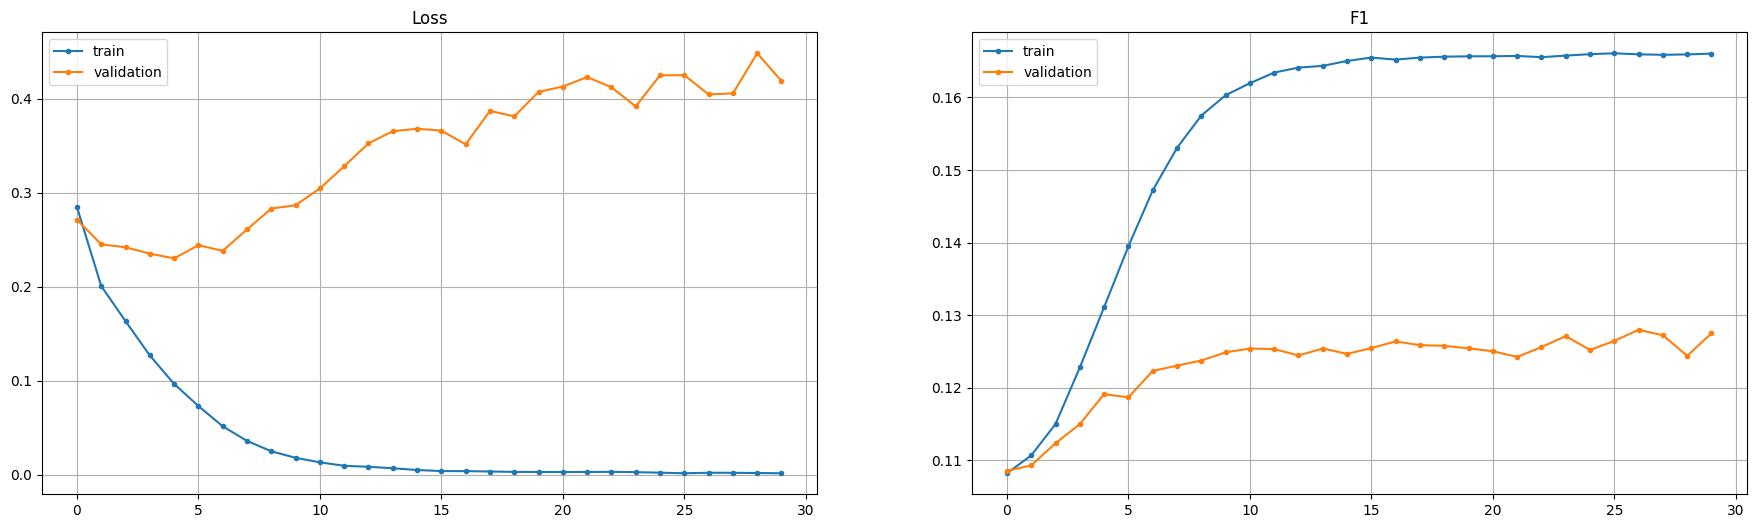

In [29]:
# NOTE: plot training and validation performance
fig, axes = plt.subplots(ncols=2, figsize=(22, 6))

axes[0].plot(np.arange(len(train_losses)), train_losses, ".-")
axes[0].plot(np.arange(len(valid_losses)), valid_losses, ".-")
axes[0].legend(["train", "validation"])
axes[0].set_title("Loss")
axes[0].grid()

axes[1].plot(np.arange(len(train_scores)), [item.mean() for item in train_scores], ".-")
axes[1].plot(np.arange(len(valid_scores)), [item.mean() for item in valid_scores], ".-")
axes[1].legend(["train", "validation"])
axes[1].set_title("F1")
axes[1].grid();

In [34]:
#######################################################################
# TODO: load model best state
#######################################################################
best_f1_score = -float('inf')  # Initialize with a very low score
best_model_state = None  # Placeholder for best model state

for epoch in range(n_epochs):
    # Training step
    train_logs = train_one_epoch(model, train_loader, criterion, optimizer, device)

    # Evaluation step
    eval_logs = evaluate(model, validation_loader, criterion, device)

    # Calculate the average F1 score for validation
    avg_f1 = eval_logs['f1'].mean()  # Assuming f1 scores are returned in logs

    # Save the best model based on validation F1 score
    if avg_f1 > best_f1_score:
        best_f1_score = avg_f1
        best_model_state = model.state_dict()  # Save the model state

# After training ends, save the best model state
torch.save(best_model_state, 'best_model.pth')


training:   1%|▏                                       | 1/169 [00:00<00:51,  3.27it/s, loss 0.0003]

<ipython-input-13-1a8d18e29ee3>:21: RuntimeWarning: invalid value encountered in scalar divide
  precision = np.nan_to_num(true_positives / (true_positives + false_positives), nan=0.0)
<ipython-input-13-1a8d18e29ee3>:22: RuntimeWarning: invalid value encountered in scalar divide
  recall = np.nan_to_num(true_positives / (true_positives + false_negatives), nan=0.0)
<ipython-input-13-1a8d18e29ee3>:23: RuntimeWarning: invalid value encountered in scalar divide
  f1_score = np.nan_to_num(2 * (precision * recall) / (precision + recall), nan=0.0)


Evaluating: 100%|███████████████████████████████████████████████████| 21/21 [00:02<00:00,  8.24it/s]
Average Loss: 0.4107, Average F1: 0.1274
Evaluating: 100%|███████████████████████████████████████████████████| 21/21 [00:02<00:00, 10.08it/s]
Average Loss: 0.4123, Average F1: 0.1277
Evaluating: 100%|███████████████████████████████████████████████████| 21/21 [00:02<00:00,  9.91it/s]
Average Loss: 0.4091, Average F1: 0.1278
Evaluating: 100%|███████████████████████████████████████████████████| 21/21 [00:02<00:00,  9.65it/s]
Average Loss: 0.4517, Average F1: 0.1259
Evaluating: 100%|███████████████████████████████████████████████████| 21/21 [00:02<00:00,  9.85it/s]
Average Loss: 0.4094, Average F1: 0.1295
Evaluating: 100%|███████████████████████████████████████████████████| 21/21 [00:02<00:00,  8.13it/s]
Average Loss: 0.4212, Average F1: 0.1279
Evaluating: 100%|███████████████████████████████████████████████████| 21/21 [00:02<00:00,  9.99it/s]
Average Loss: 0.4459, Average F1: 0.1275
Evalua

In [35]:
# Load the saved best model
best_model_state = torch.load('best_model.pth')
model.load_state_dict(best_model_state)  # Load the state dict into the model
model.eval()  # Switch the model to evaluation mode


<ipython-input-35-438a7011757c>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model_state = torch.load('best_model.pth')


NER_RNN(
  (embed): Embedding(50205, 512, padding_idx=0)
  (rnn): GRU(512, 512, num_layers=3, batch_first=True, dropout=0.2, bidirectional=True)
  (layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (fc): Linear(in_features=1024, out_features=9, bias=True)
)

In [37]:
#######################################################################
# TODO: write evaluation function for a test set.
#######################################################################
# Perform evaluation on the test set
@torch.inference_mode()
def evaluate(
    model: nn.Module,
    loader: DataLoader,
    criterion: nn.Module,
    device: str = "cpu",
    verbose: bool = True,
) -> Mapping[str, np.array]:
    """Model evaluation.

    Args:
        model: model to evaluate.
        loader: dataloader to use for evaluation.
        criterion: loss function.
        device: device to use for evaluation.
            Default is `"cpu"`.
        verbose: option to print evaluation progress bar.
            Default is `True`.

    Returns:
        dict with evaluation logs
    """
    model.eval()  # Set model to evaluation mode

    losses = []  # To store loss values
    scores = []  # To store F1 scores

    # Use tqdm to display progress bar if verbose is True
    with tqdm(total=len(loader), desc="Evaluating", file=sys.stdout, ncols=100, disable=not verbose) as progress:
        for x_batch, y_true in loader:
            x_batch = x_batch.to(device)
            y_true = y_true.to(device)

            # Forward pass
            log_prob = model(x_batch)

            B, T = y_true.shape
            loss = criterion(log_prob.view(B * T, -1), y_true.view(B * T))  # Calculate loss
            losses.append(loss.item())

            # Get predictions
            y_pred = log_prob.argmax(2).detach().cpu().numpy()
            y_true = y_true.detach().cpu().numpy()

            # Calculate F1 score for each sample in the batch
            padding_mask = y_true != NER_PAD_ID
            for i in range(x_batch.size(0)):
                scores.append(sequence_f1(y_true[i][padding_mask[i]], y_pred[i][padding_mask[i]]))

            progress.update(1)  # Update progress bar

    logs = {
        "losses": np.array(losses),  # Loss values
        "f1": np.array(scores),      # F1 scores
    }

    # Calculate average loss and F1 score
    avg_loss = np.mean(logs["losses"])
    avg_f1 = np.mean(logs["f1"])

    print(f"Average Loss: {avg_loss:.4f}, Average F1: {avg_f1:.4f}")

    return logs  # Return evaluation logs

test_logs = evaluate(model, test_loader, criterion, device)

# Print test results
print("Test Loss:", test_logs['losses'].mean())
print("Test F1 Score:", test_logs['f1'].mean())



Evaluating:   9%|████▋                                               | 1/11 [00:00<00:02,  4.66it/s]

<ipython-input-13-1a8d18e29ee3>:21: RuntimeWarning: invalid value encountered in scalar divide
  precision = np.nan_to_num(true_positives / (true_positives + false_positives), nan=0.0)
<ipython-input-13-1a8d18e29ee3>:22: RuntimeWarning: invalid value encountered in scalar divide
  recall = np.nan_to_num(true_positives / (true_positives + false_negatives), nan=0.0)
<ipython-input-13-1a8d18e29ee3>:23: RuntimeWarning: invalid value encountered in scalar divide
  f1_score = np.nan_to_num(2 * (precision * recall) / (precision + recall), nan=0.0)


Evaluating: 100%|███████████████████████████████████████████████████| 11/11 [00:02<00:00,  4.72it/s]
Average Loss: 0.5223, Average F1: 0.1297
Test Loss: 0.5223283957351338
Test F1 Score: 0.12969213568968746
